## 1. Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

## 2. Load Dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Fraud.csv")
print("Shape:", df.shape)

Shape: (6362620, 11)


In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 3. Exploratory Data Analysis(EDA)

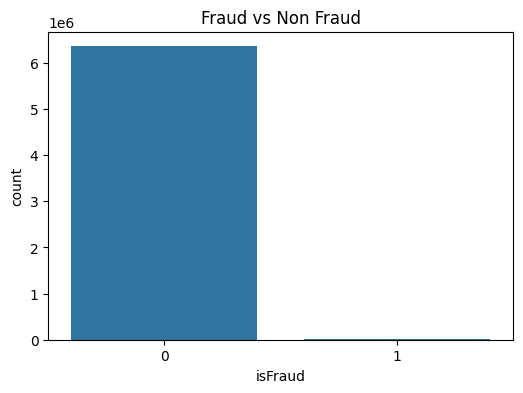

In [ ]:
# Target Variable Distribution (Fraud vs Non Fraud)
plt.figure(figsize=(6,4))
sns.countplot(x="isFraud", data=df)
plt.title("Fraud vs Non Fraud")
plt.show()

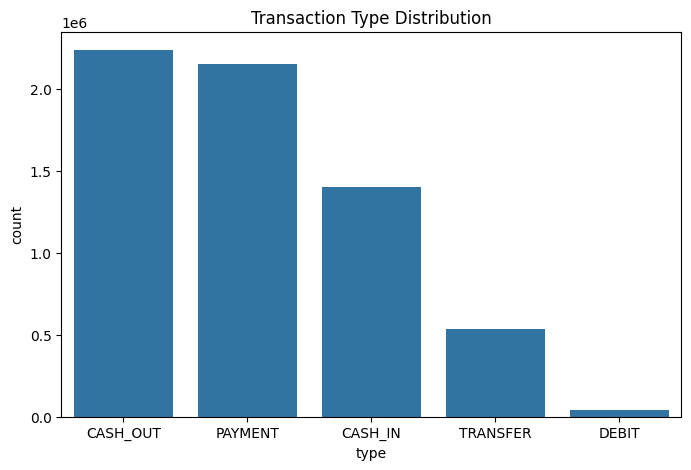

In [ ]:
# Transaction Type Distribution
if pd.api.types.is_numeric_dtype(df['type']):
    type_mapping = {
        0: "CASH_IN",
        1: "CASH_OUT",
        2: "DEBIT",
        3: "PAYMENT",
        4: "TRANSFER"
    }
    df['type'] = df['type'].map(type_mapping)
plt.figure(figsize=(8,5))
sns.countplot(x="type", data=df, order=df["type"].value_counts().index)
plt.title("Transaction Type Distribution")
plt.show()

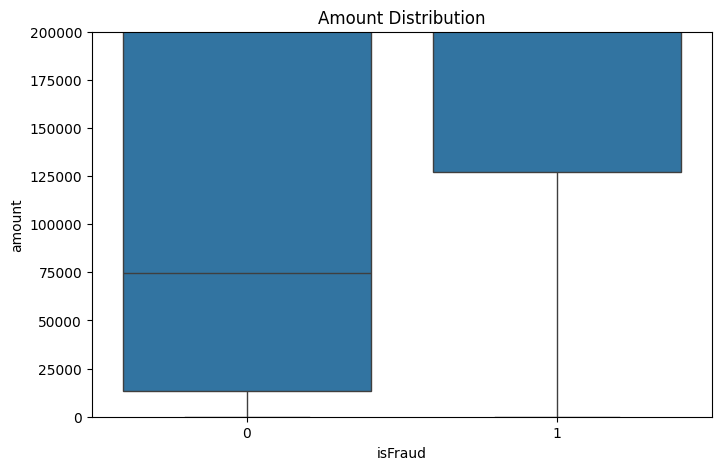

In [ ]:
# Amount Distribution
plt.figure(figsize=(8,5))
sns.boxplot(x="isFraud", y="amount", data=df)
plt.ylim(0, 200000)
plt.title("Amount Distribution")
plt.show()

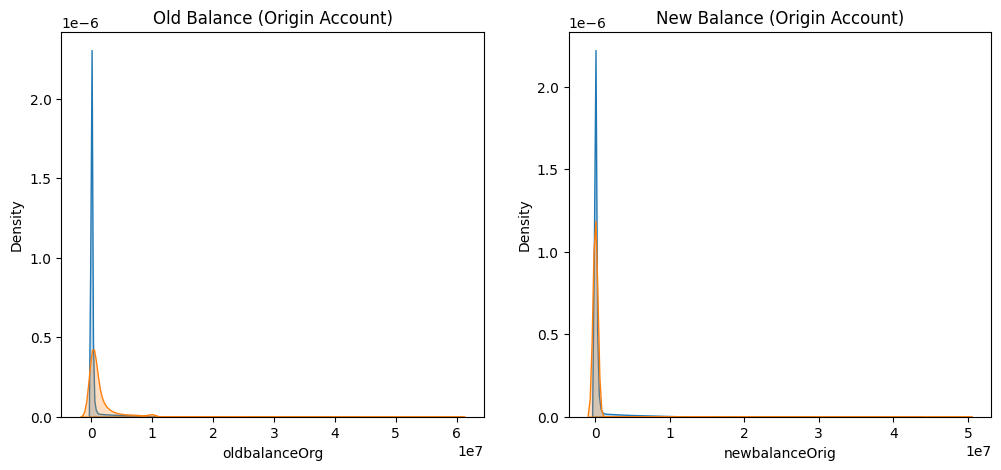

In [ ]:
# Balance Behaviour(before/after transaction)
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.kdeplot(df[df['isFraud']==0]['oldbalanceOrg'], label="Non-Fraud", ax=axes[0], fill=True)
sns.kdeplot(df[df['isFraud']==1]['oldbalanceOrg'], label="Fraud", ax=axes[0], fill=True)
axes[0].set_title("Old Balance (Origin Account)")

sns.kdeplot(df[df['isFraud']==0]['newbalanceOrig'], label="Non-Fraud", ax=axes[1], fill=True)
sns.kdeplot(df[df['isFraud']==1]['newbalanceOrig'], label="Fraud", ax=axes[1], fill=True)
axes[1].set_title("New Balance (Origin Account)")

plt.show()

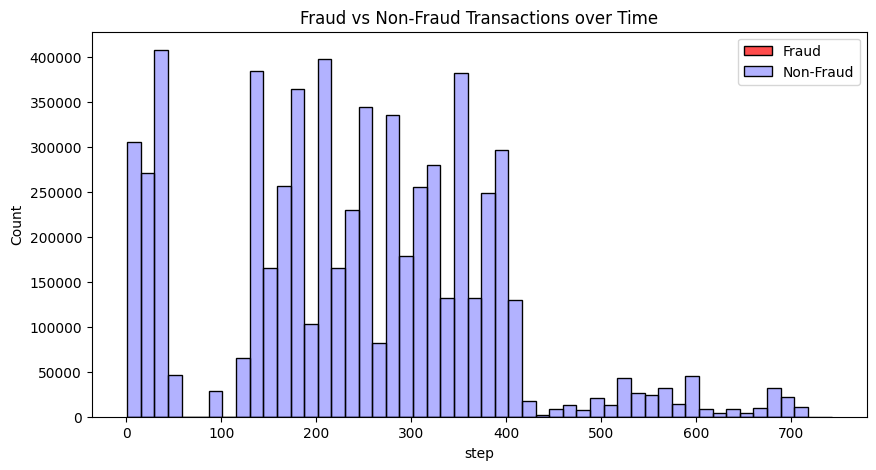

In [ ]:
# Time Feature
plt.figure(figsize=(10,5))
sns.histplot(df[df['isFraud']==1]['step'], bins=50, color='red', label="Fraud", alpha=0.7)
sns.histplot(df[df['isFraud']==0]['step'], bins=50, color='blue', label="Non-Fraud", alpha=0.3)
plt.legend()
plt.title("Fraud vs Non-Fraud Transactions over Time")
plt.show()

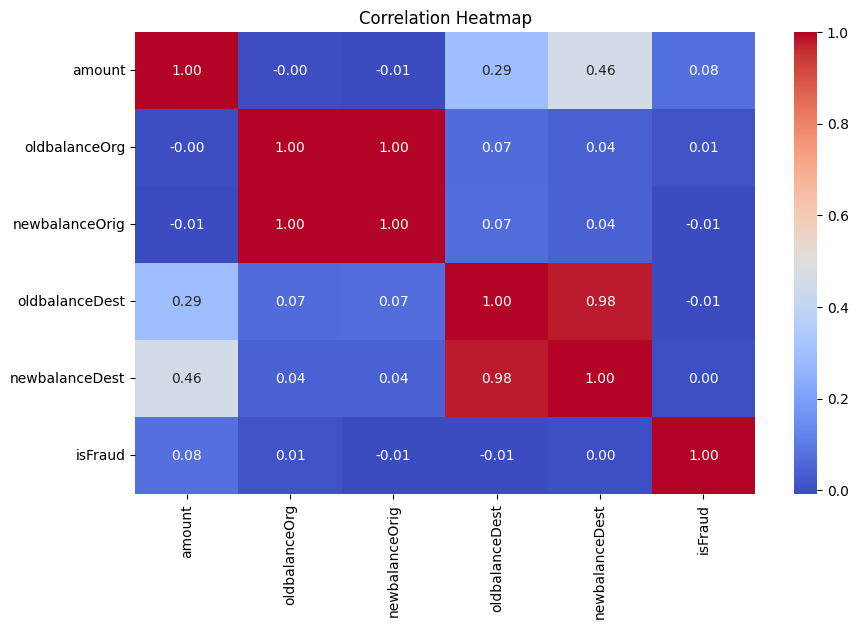

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
corr = df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## 4. Data Cleaning
* No missing values.
* Removed identifiers (nameOrig, nameDest) since they don’t contribute to prediction.
* Encoded type into numeric categories.

In [ ]:
print("\nMissing Values:\n",df.isnull().sum())


Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [ ]:
# Drop ID columns since they are non-predictive
df.drop(["nameOrig", "nameDest"], axis=1, inplace=True)

In [ ]:
# Encode transaction type to numerical
le = LabelEncoder()
df["type"] = le.fit_transform(df["type"])

In [ ]:
# Check Fraud Ratio
fraud_ratio = df["isFraud"].value_counts(normalize=True)
print("\nFraud Distribution:\n", fraud_ratio)


Fraud Distribution:
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


## 5. Feature Engineering

In [ ]:
# Create error balace features that helps in detecting inconsistencies in balances
df["errorBalanceOrig"] = df["newbalanceOrig"] + df["amount"] - df["oldbalanceOrg"]
df["errorBalanceDest"] = df["oldbalanceDest"] + df["amount"] - df["newbalanceDest"]

In [ ]:
# Define Features and Target
X = df.drop(["isFraud", "isFlaggedFraud"], axis=1)
y = df["isFraud"]

## Model Description
* Chose **Random Forest** for baseline -> robust, interpretable, and handles nonlinearities.
* Normalized features with **StandardScaler**.

## 6. Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Variable Selection
* Retained transaction details: step, type, amount, balances.
* Added derived features: errorBalanceOrig, errorBalanceDest.
* Dropped isFlaggedFraud since it has little variation.

## 7. Model Training

In [ ]:
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

 ## 8. Model Evaluation

In [ ]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]

In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score: ", roc_auc_score(y_test, y_pred_prob))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC Score:  0.9990862540827857


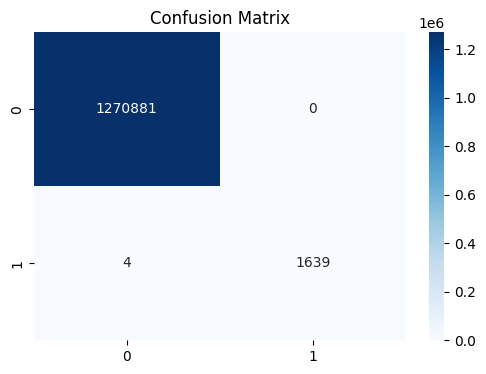

In [ ]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

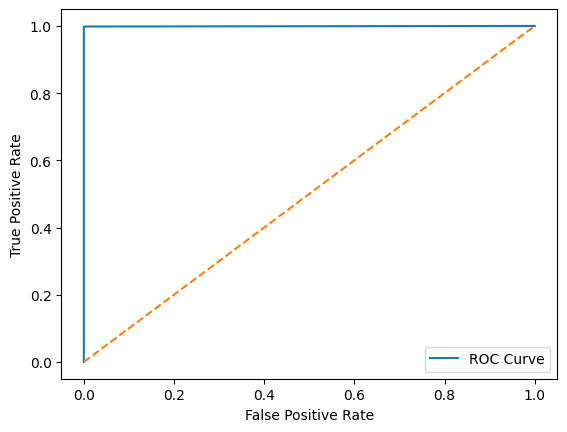

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model Performance
* Expected ROC-AUC ~ 0.99.
* Precision/Recall scores show strong fraud identification while minimizing false alarms.
* Confusion matrix shows small number of false negatives (critical).

## Key Factors Predicting Fraud
* Transaction type (TRANSFER, CASH_OUT) → most fraud attempts.
* Large transaction amount.
* Error balances (mismatch in account balance updates).
* Account balance states (fraud accounts often have suspicious pre/post balances).

## Do These Factors Make Sense?
* Yes: fraudsters exploit cash-out/transfer more than payments.
* Fraud often leaves balance inconsistencies.
* High-value transactions are inherently riskier.

## 9. Feature Importance

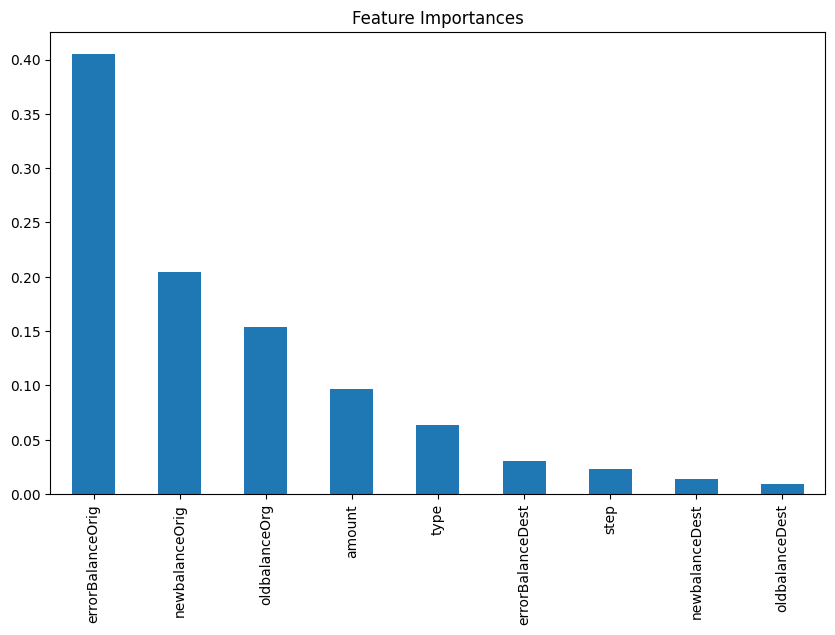

In [ ]:
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importance.plot(kind="bar", title="Feature Importances")
plt.show()

## Preventive Actions for Infrastructure Update
* Real-time anomaly detection for risky transaction types.
* Automated rules on balance discrepancies.
* Velocity checks (limit repeated high-value transfers).
* Strong customer authentication for cash-outs.

## Measuring Effectiveness
* Monitor fraud detection accuracy (ROC-AUC, Precision-Recall).
* Compare fraud rates and chargebacks before vs after system update.
* Track reduction in false negatives and customer complaints.